# Model Testing – Clustering Algorithm Comparison

This notebook explores and benchmarks several clustering approaches on our customer dataset, including:

1. **K-Means** over different feature subsets  
2. **DBSCAN** for density-based segmentation  
3. **Agglomerative (hierarchical) clustering** for comparison  

The goal is to identify which algorithm and feature combination produces the most coherent, stable, and actionable customer segments.

**Key Objectives & Workflow:**

1. **K-Means Experiments**  
   - For each feature subset:  
     - Loop \(k\) over a sensible range (e.g. 2–10).  
     - Compute technical metrics:  
       - **Inertia** (elbow method)  
       - **Silhouette score**  
       - **Calinski–Harabasz index**  
       - **Davies–Bouldin index**  
     - Visualize the elbow and silhouette charts.  
     - Select a `best_k` balancing metric peaks and business interpretability (cluster sizes, profiles).  
     - Profile each segment (mean and distribution of input features).  
     - Visualize cluster structure with t-SNE.

3. **DBSCAN Experiments**  
   - Tune **eps** (distance threshold) with a fixed **min_samples** (e.g. 100 and 10).  
   - Plot the 5th-nearest-neighbor distance curve to guide eps selection.  
   - For each eps/min_samples pair:  
     - Run DBSCAN, record: number of clusters, number of noise points, silhouette score on non-noise points.  
     - Visualize cluster assignments (2D scatter and t-SNE).  
   - Assess whether DBSCAN yields meaningful, well-sized segments or too many noise points.

4. **Agglomerative Clustering**  
   - Work on a random subsample (e.g. 10 000 points) for computational tractability.  
   - Compare different linkage methods (complete, average, single) via dendrogram or distance plot.  
   - For each linkage and a range of \(k\):  
     - Compute silhouette scores.  
     - Select best linkage + \(k\) and profile clusters.  
     - Visualize with t-SNE on the subsample.

## Load Data

In [1]:
# Libraries
import warnings
import os
import time as time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import mpl_toolkits.mplot3d

from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE, trustworthiness
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance

# Set-up environment
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_colwidth', None)
os.chdir('/Users/nataschajademinnitt/Documents/5. Data Analysis/segmenting_customers/')

print("Current directory:", os.getcwd())
warnings.filterwarnings("ignore")

Current directory: /Users/nataschajademinnitt/Documents/5. Data Analysis/segmenting_customers


In [3]:
# Load the data
df = pd.read_csv("./data/processed/processed_database.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93347 entries, 0 to 93346
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_unique_id        93347 non-null  object 
 1   order_purchase_timestamp  93347 non-null  object 
 2   recency                   93347 non-null  int64  
 3   f_returning               93347 non-null  int64  
 4   m_price                   93347 non-null  float64
 5   m_price_log               93347 non-null  float64
 6   m_purchasing_power        93347 non-null  int64  
 7   m_total_installments      93347 non-null  float64
 8   product_score             93347 non-null  float64
 9   s_review_score            93347 non-null  float64
 10  s_delivery_diff           93347 non-null  float64
dtypes: float64(6), int64(3), object(2)
memory usage: 7.8+ MB


In [5]:
all_features = ['recency', 'f_returning',
                'm_price', 'm_purchasing_power', 'm_total_installments', 
                'product_score', 's_review_score', 's_delivery_diff']
df[all_features].describe()

recency  f_returning  m_price  m_purchasing_power  \
count 93347.00     93347.00 93347.00            93347.00   
mean    236.94         0.03   141.62                0.55   
std     152.58         0.17   215.71                0.50   
min       0.00         0.00     0.85                0.00   
25%     113.00         0.00    47.65                0.00   
50%     218.00         0.00    89.70                1.00   
75%     345.00         0.00   154.69                1.00   
max     694.00         1.00 13440.00                1.00   

       m_total_installments  product_score  s_review_score  s_delivery_diff  
count              93347.00       93347.00        93347.00         93347.00  
mean                   2.97           5.29            4.15           -11.15  
std                    2.72           2.64            1.28            10.14  
min                    0.00          -3.50            1.00          -146.02  
25%                    1.00           3.27            4.00           -16.23  
50%                    2.00           6.18            5.00           -11.75  
75%                    4.00           7.45            5.00            -6.39  
max                   26.00           9.00            5.00           188.98

## Functions

In [9]:
def evaluate_k_metrics(
    df,
    features,
    k_min=2,
    k_max=10,
    random_state=42,
    save_fig=False,
    fig_path="./plots/tests/elbow_kmeans.png"
):
    """
    1) Scale features.
    2) Compute silhouette, Calinski-Harabasz, and Davies-Bouldin scores for k in [k_min, k_max].
    3) Plot distortion elbow visualizer.
    """
    # Scale data
    X = df[features].values
    scaler = StandardScaler().fit(X)
    Xs = scaler.transform(X)

    # Metrics table
    metrics = []
    for k in range(k_min, k_max + 1):
        km = KMeans(n_clusters=k, random_state=random_state).fit(Xs)
        labels = km.labels_
        metrics.append({
            'k': k,
            'silhouette': silhouette_score(Xs, labels),
            'calinski_harabasz': calinski_harabasz_score(Xs, labels),
            'davies_bouldin': davies_bouldin_score(Xs, labels)
        })
    df_metrics = pd.DataFrame(metrics).set_index('k')
    print("Clustering metrics:\n", df_metrics)

    # Elbow visualizer
    fig, ax = plt.subplots(figsize=(6, 4))
    kelbow = KElbowVisualizer(
        KMeans(random_state=random_state),
        k=(k_min, k_max),
        metric='distortion',
        ax=ax
    )
    kelbow.fit(Xs)
    kelbow.finalize()
    best_k = kelbow.elbow_value_

    plt.tight_layout()
    if save_fig:
        os.makedirs(os.path.dirname(fig_path), exist_ok=True)
        fig.savefig(fig_path, dpi=150)
    plt.show()

    return scaler, df_metrics, best_k

In [11]:
def fit_best_k(
    df,
    features,
    scaler,
    k,
    features_interpret=None,
    random_state=42,
    save_fig=False,
    fig_path="./plots/tests/silhouette_kmeans.png"
):
    """
    1) Fit KMeans(k) on scaled features.
    2) Plot silhouette.
    3) Assign df['cluster'], print counts & mean profiles.
    """
    # Fit KMeans
    Xs = scaler.transform(df[features].values)
    km = KMeans(n_clusters=k, random_state=random_state).fit(Xs)
    df['cluster'] = km.labels_

    # Silhouete plot
    fig, ax = plt.subplots(figsize=(8,6))
    silvis = SilhouetteVisualizer(km, ax=ax)
    silvis.fit(Xs); silvis.finalize()
    plt.tight_layout()
    if save_fig:
        os.makedirs(os.path.dirname(fig_path), exist_ok=True)
        fig.savefig(fig_path, dpi=150)
    plt.show()

    # Assign 'cluster'
    counts = df['cluster'].value_counts().sort_index()
    print("Cluster counts:\n", counts.to_frame(name='count'))
    if features_interpret is None:
        features_interpret = features
    profiles = df.groupby('cluster')[features_interpret].mean().round(2)
    print("Cluster profiles:\n")
    display(profiles)

    return km, profiles

In [13]:
def visualise_clusters(
    df,
    features,
    scaler,
    km,
    subsample_size=10000,
    tsne_perplexity=40,
    random_state=42,
    save_fig=False,
    fig_dir="./plots/tests/tsne",
    cluster_col='cluster'
):
    """
    1) Randomly subsample df.
    2) Run t-SNE on scaled features.
    3) Plot t-SNE colored by cluster and by each feature in features.
    """
    
    if save_fig:
        os.makedirs(fig_dir, exist_ok=True)
        
    # Subsample
    idx = np.random.RandomState(random_state).choice(
        len(df), size=min(subsample_size, len(df)), replace=False
    )
    df_sub = df.iloc[idx].copy()
    
    # t-SNE embedding
    X_sub = scaler.transform(df_sub[features].values)
    tsne = TSNE(
        n_components=2,
        perplexity=tsne_perplexity,
        init='pca',
        random_state=random_state
    )
    Y = tsne.fit_transform(X_sub)
    df_sub['tsne1'], df_sub['tsne2'] = Y[:,0], Y[:,1]
    
    # Plot clusters
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        data=df_sub, x='tsne1', y='tsne2',
        hue=cluster_col, palette='tab10',
        s=30, alpha=0.6
    )
    plt.title(f"t-SNE Visualization by Cluster (k={km.n_clusters})")
    plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
    plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    if save_fig:
        plt.savefig(f"{fig_dir}/tsne_clusters_k{km.n_clusters}.png", dpi=150)
    plt.show()
    
    # Plot each feature
    for feat in features:
        plt.figure(figsize=(8,6))
        sc = plt.scatter(
            df_sub['tsne1'], df_sub['tsne2'],
            c=df_sub[feat], cmap='viridis',
            s=30, alpha=0.7
        )
        plt.title(f"t-SNE colored by {feat}")
        plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
        plt.colorbar(sc, label=feat)
        plt.tight_layout()
        if save_fig:
            plt.savefig(f"{fig_dir}/tsne_{feat}.png", dpi=150)
        plt.show()
    
    return df_sub

## K-Means Clustering

### Model 0: RFM

Clustering metrics:
    silhouette  calinski_harabasz  davies_bouldin
k                                               
2        0.72           48159.87            0.40
3        0.36           61511.62            0.90
4        0.37           76705.56            0.76
5        0.35           76911.33            0.82
6        0.34           77730.53            0.86
7        0.36           80826.45            0.75
8        0.35           79838.19            0.80


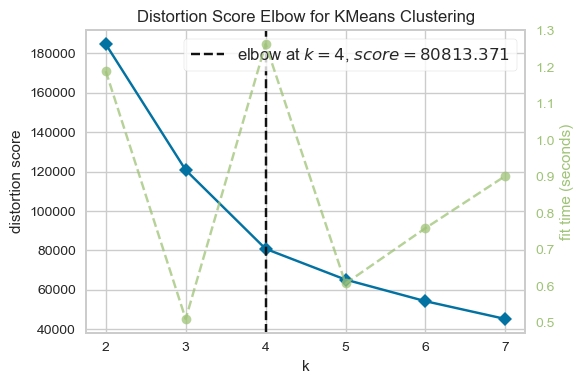

In [15]:
# 1) Evaluate cluster matrics
scaler, metrics, best_k = evaluate_k_metrics(
    df,
    features=['recency','f_returning','m_price_log'],
    k_min=2, k_max=8,
    save_fig=True,
    fig_path="./plots/tests/rfm/elbow_silhouette_rfm.png"
)

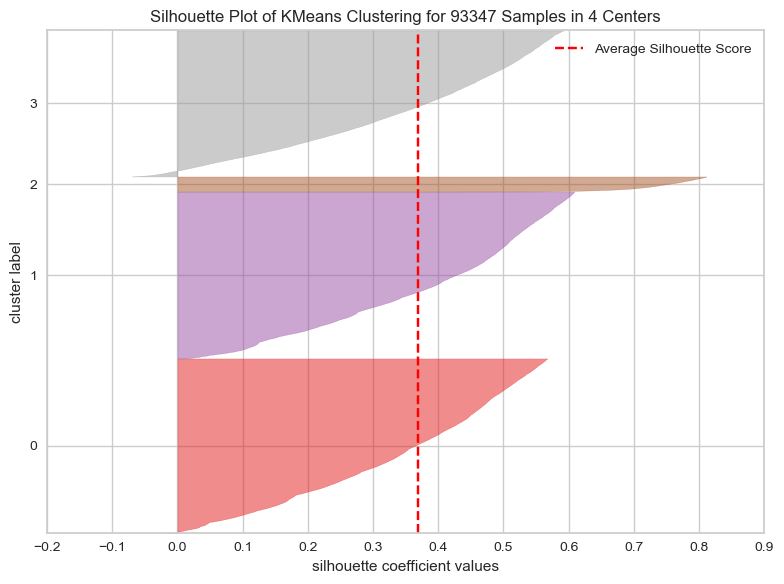

Cluster counts:
          count
cluster       
0        32393
1        31013
2         2801
3        27140
Cluster profiles:



recency  f_returning  m_price
cluster                               
0         160.34         0.00   251.03
1         153.69         0.00    44.41
2         219.29         1.00   260.05
3         425.32         0.00   109.89

In [17]:
# 2) Fit at chosen k, get profiles
km_model, cluster_profiles = fit_best_k(
    df,
    features=['recency','f_returning','m_price_log'],
    scaler=scaler,
    k=best_k,
    features_interpret=['recency','f_returning','m_price'],
    save_fig=True,
    fig_path="./plots/tests/rfm/silhouette_kmeans_RFM.png"
)

Clustering profiles 

0. New, high spenders
1. Returners, high spenders
2. First-time, high spenders
3. Dormant, moderate spenders

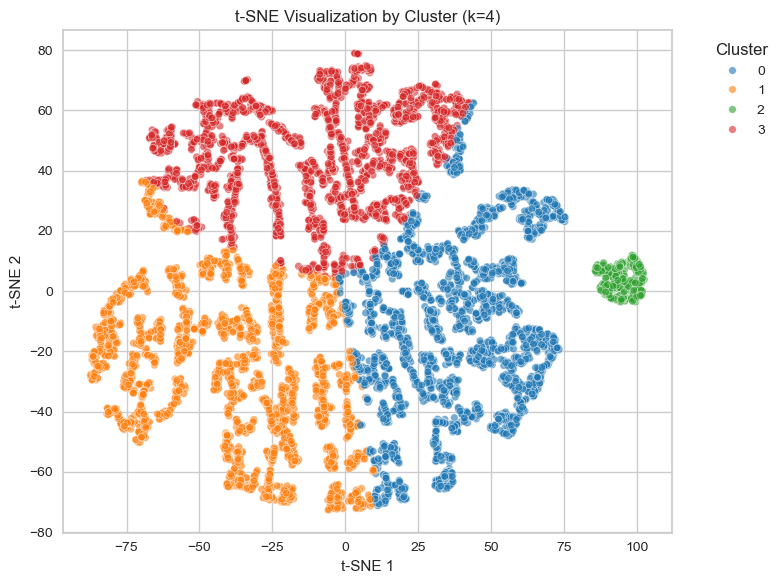

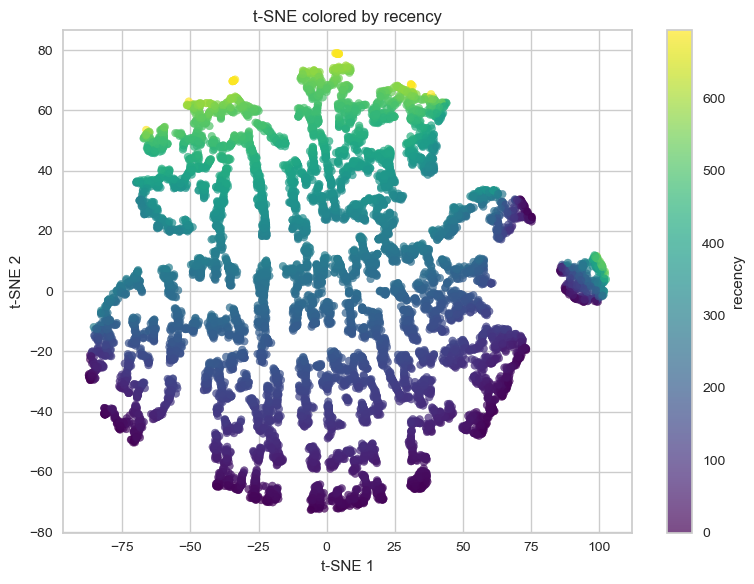

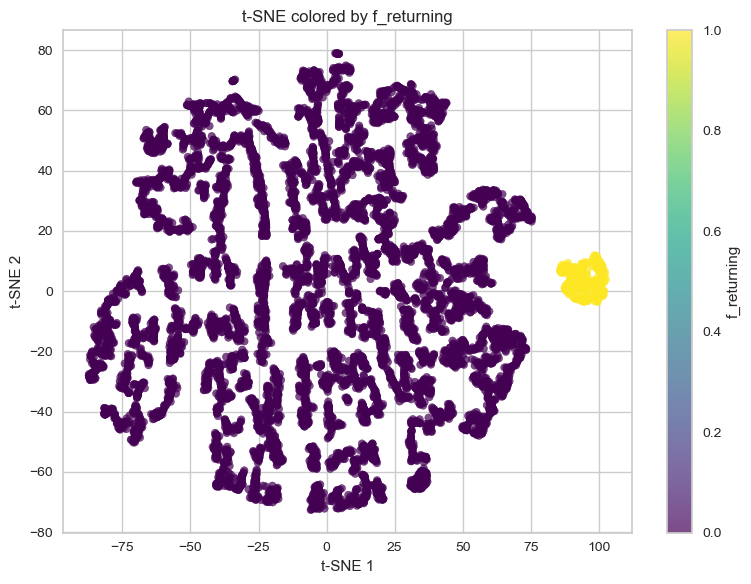

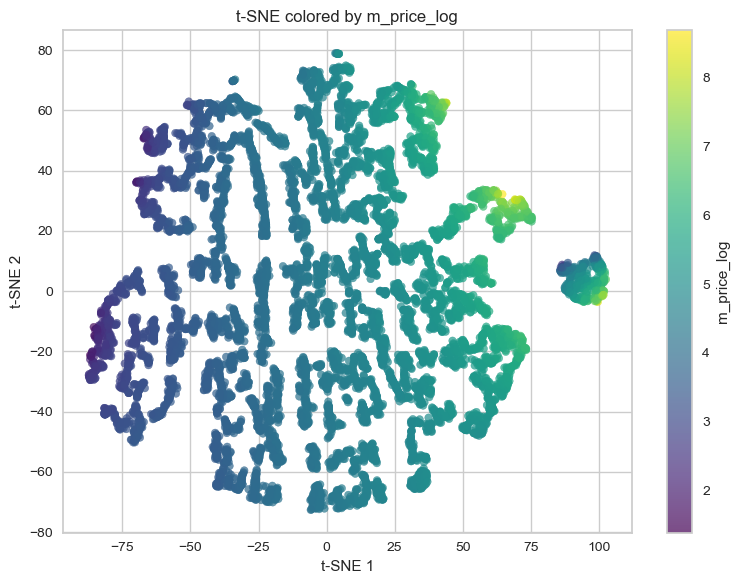

In [19]:
# 3) t-SNE visualization
df_sub = visualise_clusters(
    df,
    features=['recency','f_returning','m_price_log'],
    scaler=scaler,
    km=km_model,
    subsample_size=10000,
    tsne_perplexity=40,
    save_fig=True,
    fig_dir="./plots/tests/rfm"
)

### Model 1: RFM + review score

Clustering metrics:
    silhouette  calinski_harabasz  davies_bouldin
k                                               
2        0.37           23623.67            1.65
3        0.36           38432.31            1.00
4        0.33           46384.12            0.97
5        0.32           51211.60            0.88
6        0.30           49239.70            0.95
7        0.29           46605.31            1.01
8        0.28           44878.59            1.11


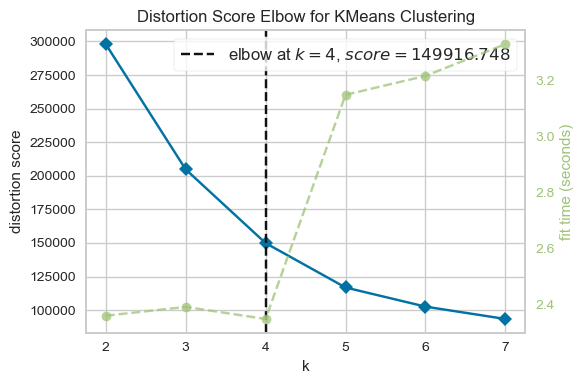

In [281]:
# 1) Evaluate cluster matrics
scaler, metrics, best_k = evaluate_k_metrics(
    df,
    features=['recency','f_returning','m_price_log', 's_review_score'],
    k_min=2, k_max=8,
    save_fig=True,
    fig_path="./plots/tests/rfm_review/elbow_silhouette_rfm_review.png"
)

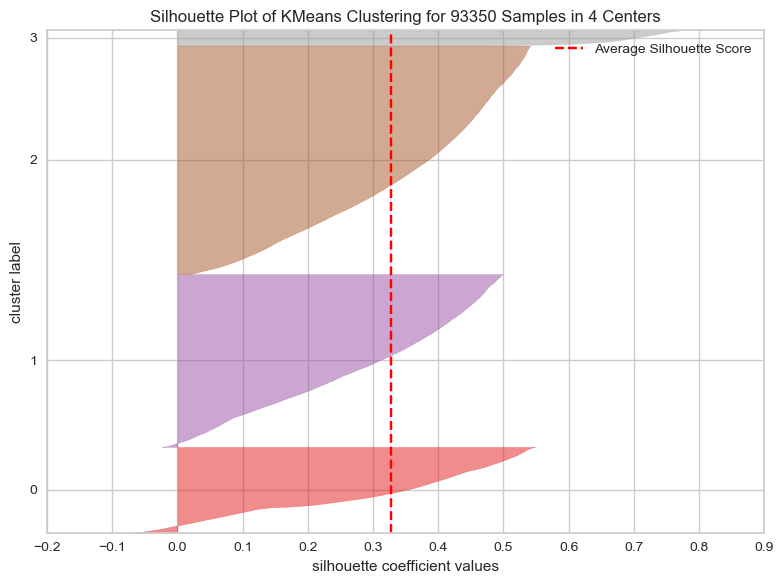

Cluster counts:
          count
cluster       
0        15944
1        32131
2        42474
3         2801
Cluster profiles:



recency  f_returning  m_price  s_review_score
cluster                                               
0         230.25         0.00   158.70            1.72
1         393.16         0.00   137.14            4.63
2         122.46         0.00   130.79            4.70
3         219.29         1.00   260.05            4.20

In [288]:
# 2) Fit at chosen k, get profiles
km_model, cluster_profiles = fit_best_k(
    df,
    features=['recency','f_returning','m_price_log', 's_review_score'],
    scaler=scaler,
    k=best_k,
    features_interpret=['recency','f_returning','m_price', 's_review_score'],
    save_fig=True,
    fig_path="./plots/tests/rfm_review/silhouette_kmeans_rfm_review.png"
)

0. “Dissatisfied Newcomers”
It’s been ~7.5 months since their only purchase, they haven’t returned, and they gave very low review scores.
Action: Investigate root causes (product quality, delivery issues), send a service-recovery offer.

1. “Dormant Happy Buyers”
They last bought > 13 months ago, never returned, but left great reviews.
Action: Run a “we miss you” campaign—exclusive promo codes or product updates to re-engage a satisfied base.

2. “Recent First-Timers (Delighted)”
Purchased ~4 months ago, haven’t come back yet, and loved it.
Action: Trigger a loyalty program invitation or cross-sell complementary products to convert them into repeat customers.

4. “Repeat High-Value Customers”
Ordered ~7 months ago, they have come back, and they spend the most—but their satisfaction is slightly lower.
Action: Offer VIP perks or a satisfaction check-in to keep them loyal and lift review scores.

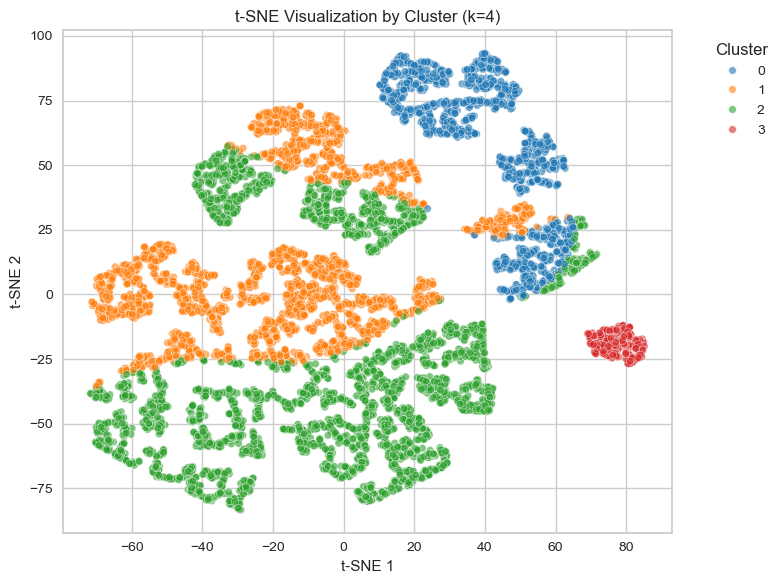

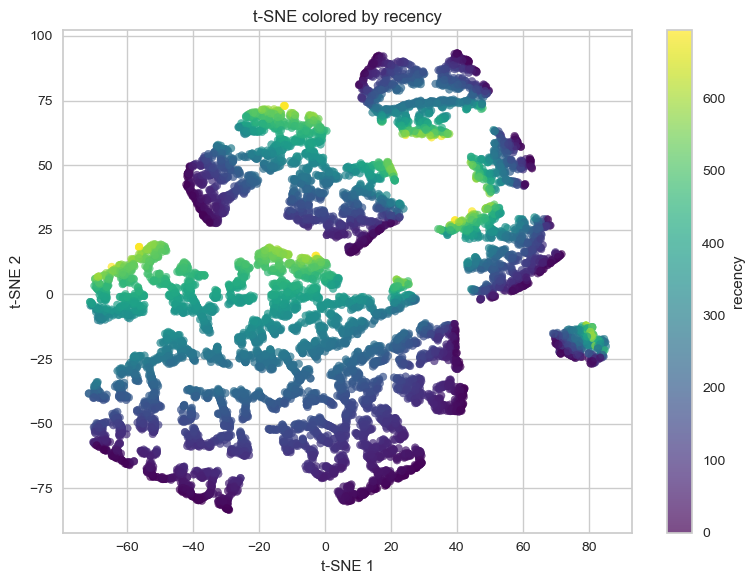

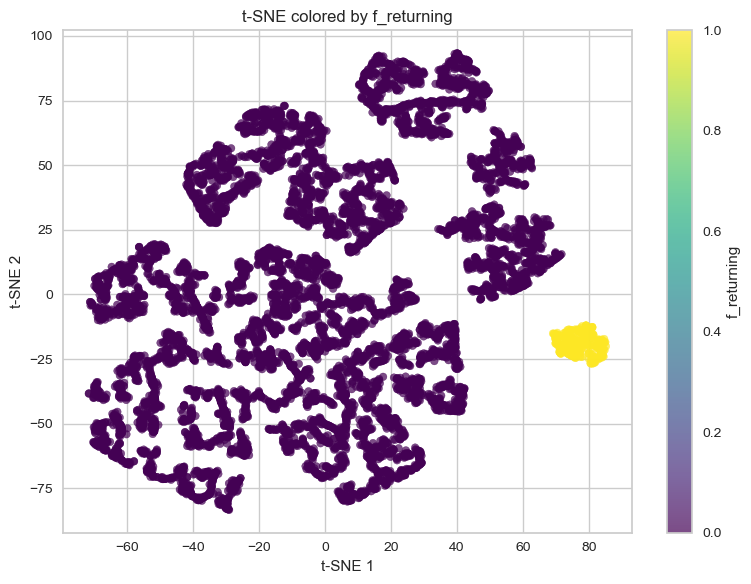

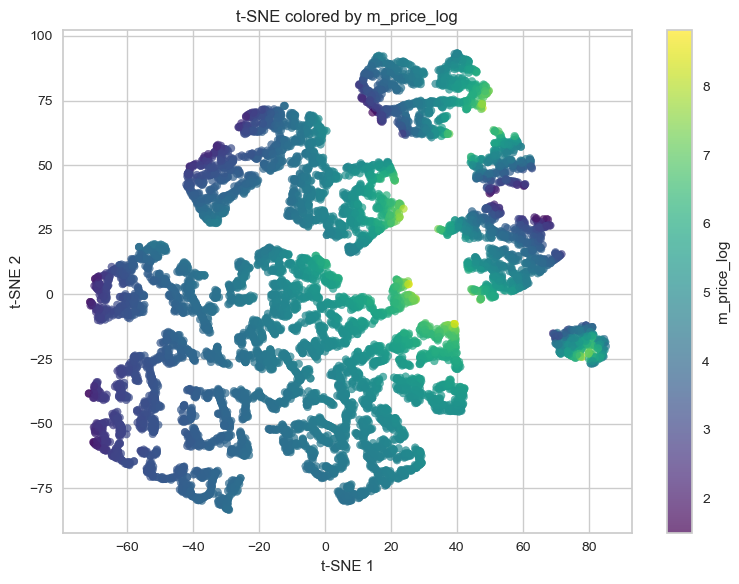

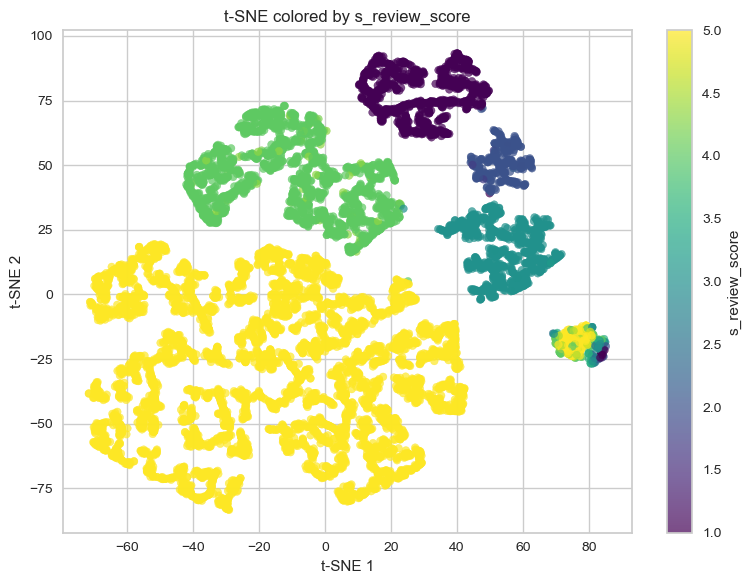

In [292]:
# 3) t-SNE visualization
df_sub = visualise_clusters(
    df,
    features=['recency','f_returning','m_price_log', 's_review_score'],
    scaler=scaler,
    km=km_model,
    subsample_size=10000,
    tsne_perplexity=40,
    save_fig=True,
    fig_dir="./plots/tests/rfm_review"
)

### Model 2: RFM + delivery diff

Clustering metrics:
    silhouette  calinski_harabasz  davies_bouldin
k                                               
2        0.23           20469.81            1.66
3        0.27           35195.11            1.15
4        0.26           36775.86            1.08
5        0.28           36871.67            0.99
6        0.25           35168.51            1.06
7        0.25           34310.75            1.07
8        0.25           33426.18            1.08


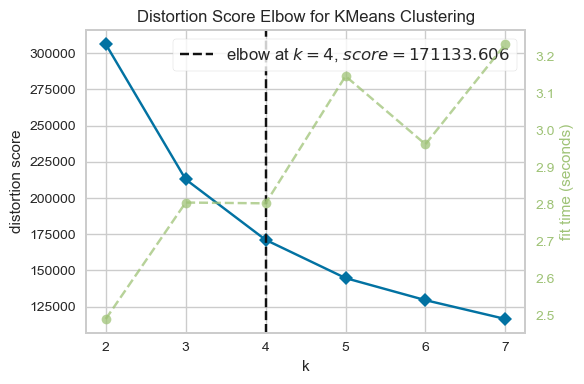

In [296]:
# 1) Evaluate cluster matrics
scaler, metrics, best_k = evaluate_k_metrics(
    df,
    features=['recency','f_returning','m_price_log', 's_delivery_diff'],
    k_min=2, k_max=8,
    save_fig=True,
    fig_path="./plots/tests/rfm_delivery/elbow_silhouette_rfm_delivery.png"
)

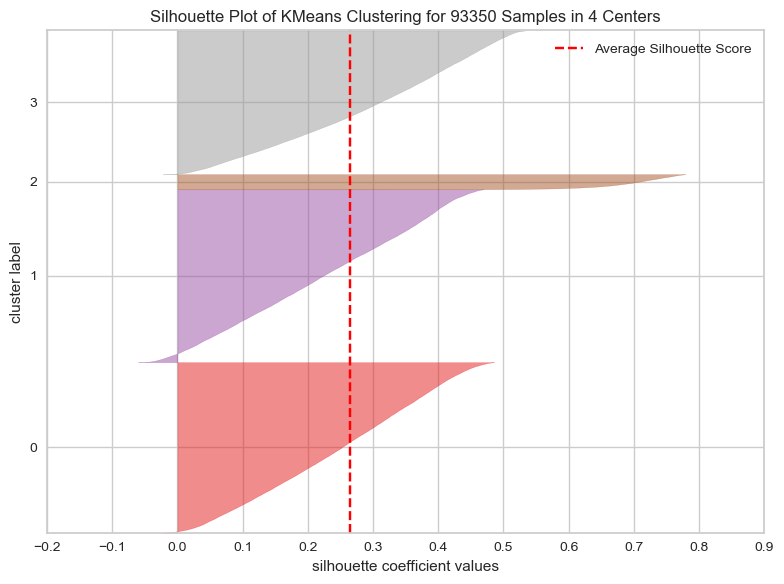

Cluster counts:
          count
cluster       
0        31693
1        32139
2         2801
3        26717
Cluster profiles:



recency  f_returning  m_price  s_delivery_diff
cluster                                                
0         158.55         0.00   249.73           -13.42
1         159.23         0.00    51.64            -6.48
2         219.29         1.00   260.05           -11.90
3         425.29         0.00   109.21           -14.00

In [299]:
# 2) Fit at chosen k, get profiles
km_model, cluster_profiles = fit_best_k(
    df,
    features=['recency','f_returning','m_price_log', 's_delivery_diff'],
    scaler=scaler,
    k=best_k,
    features_interpret=['recency','f_returning','m_price', 's_delivery_diff'],
    save_fig=True,
    fig_path="./plots/tests/rfm_delivery/silhouette_kmeans_rfm_delivery.png"
)

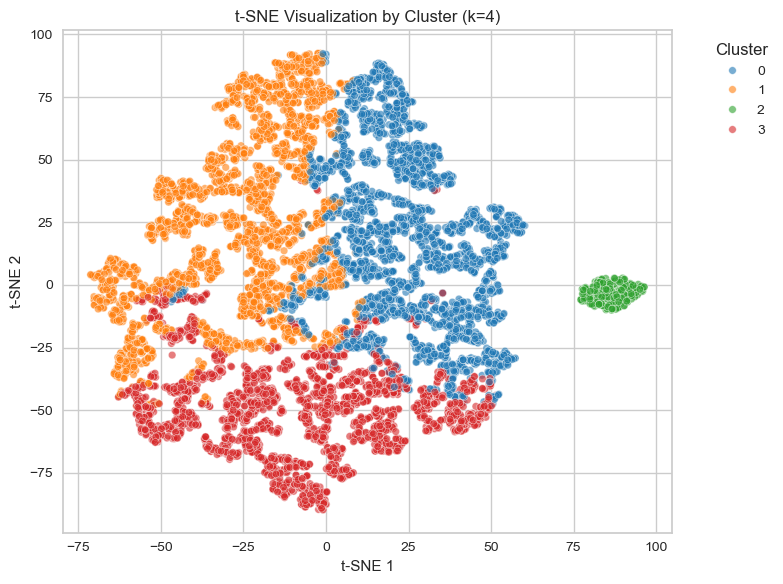

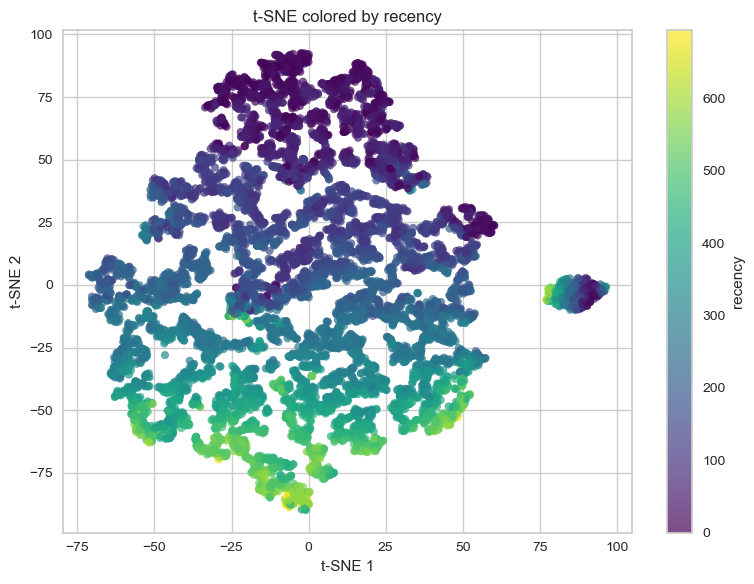

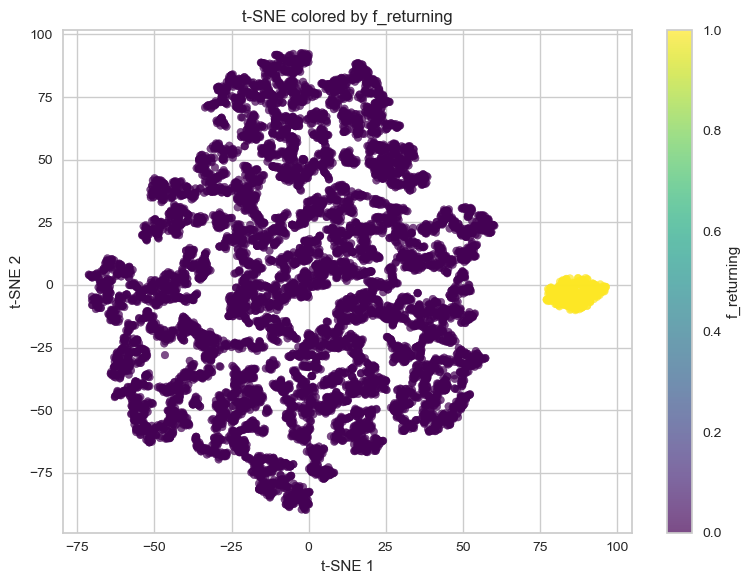

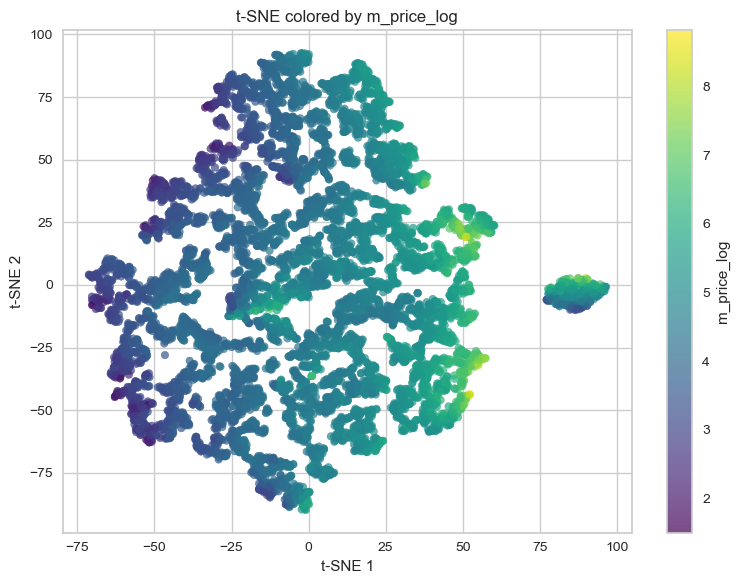

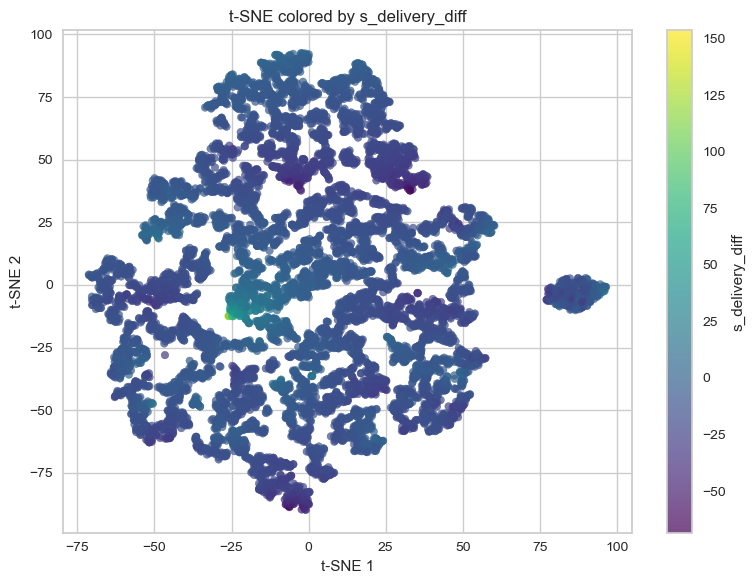

In [303]:
# 3) t-SNE visualization
df_sub = visualise_clusters(
    df,
    features=['recency','f_returning','m_price_log', 's_delivery_diff'],
    scaler=scaler,
    km=km_model,
    subsample_size=10000,
    tsne_perplexity=40,
    save_fig=True,
    fig_dir="./plots/tests/rfm_delivery"
)

### Model 3: RFM + purchasing power

Clustering metrics:
    silhouette  calinski_harabasz  davies_bouldin
k                                               
2        0.65           31998.81            0.54
3        0.38           46497.48            0.99
4        0.35           46134.84            0.99
5        0.35           47435.40            1.01
6        0.35           49932.25            0.92
7        0.36           54126.45            0.84
8        0.35           52984.24            0.86


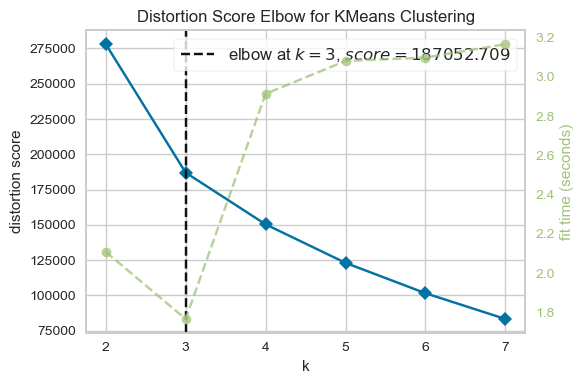

In [305]:
# 1) Evaluate cluster matrics
scaler, metrics, best_k = evaluate_k_metrics(
    df,
    features=['recency','f_returning','m_price_log', 'm_purchasing_power'],
    k_min=2, k_max=8,
    save_fig=True,
    fig_path="./plots/tests/rfm_delivery/elbow_silhouette_rfm_pp.png"
)

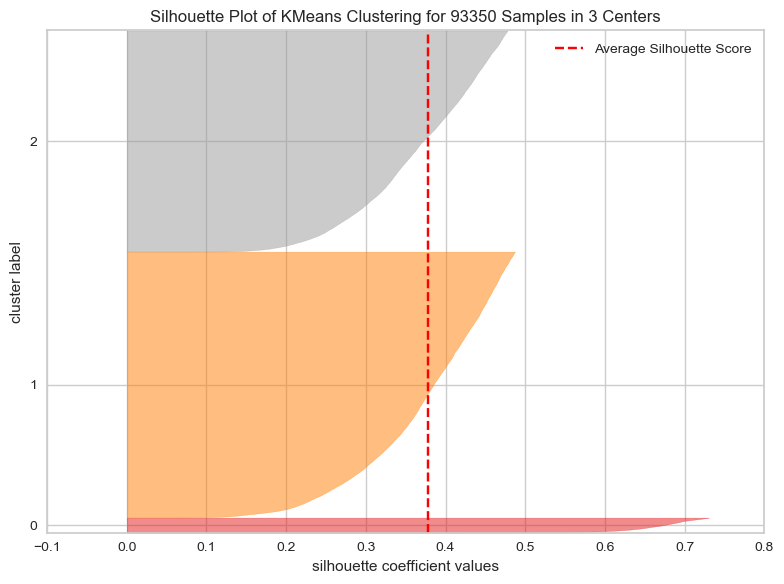

Cluster counts:
          count
cluster       
0         2801
1        49442
2        41107
Cluster profiles:



recency  f_returning  m_price  m_purchasing_power
cluster                                                   
0         219.29         1.00   260.05                0.58
1         231.73         0.00   129.76                1.00
2         244.43         0.00   147.82                0.00

In [314]:
# 2) Fit at chosen k, get profiles
km_model, cluster_profiles = fit_best_k(
    df,
    features=['recency','f_returning','m_price_log', 'm_purchasing_power'],
    scaler=scaler,
    k=best_k,
    features_interpret=['recency','f_returning','m_price', 'm_purchasing_power'],
    save_fig=True,
    fig_path="./plots/tests/rfm_purchasing/silhouette_kmeans_rfm_pp.png"
)

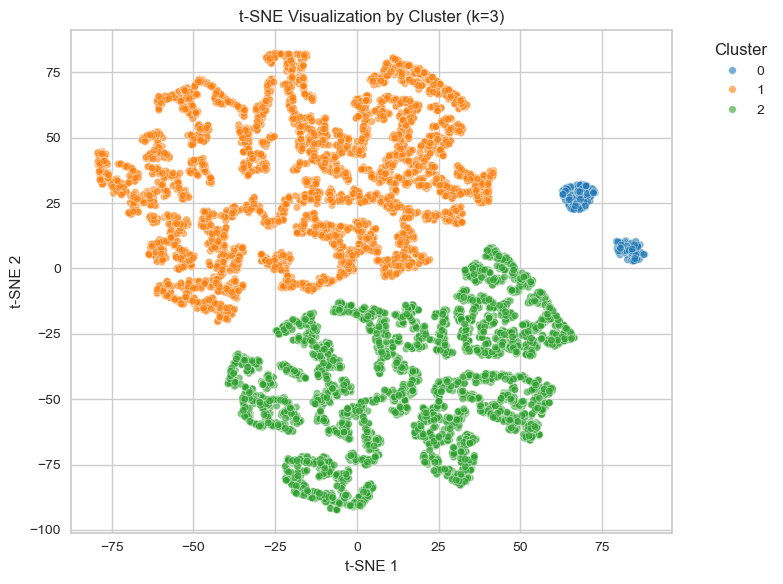

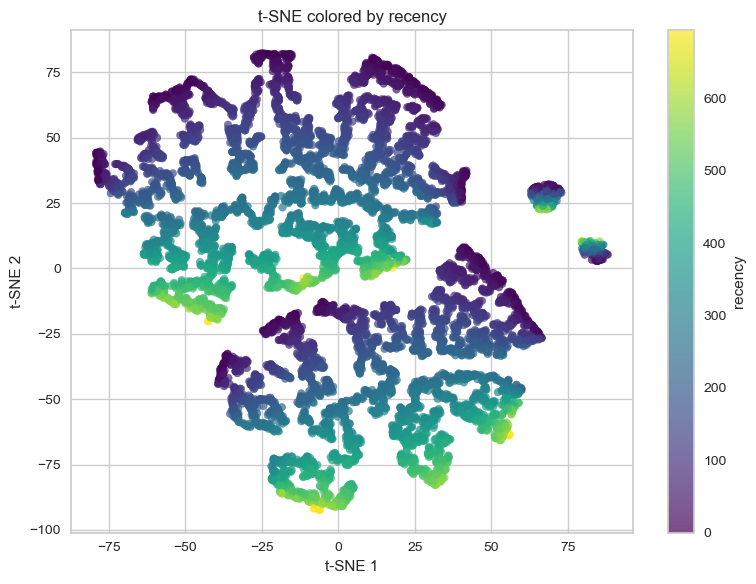

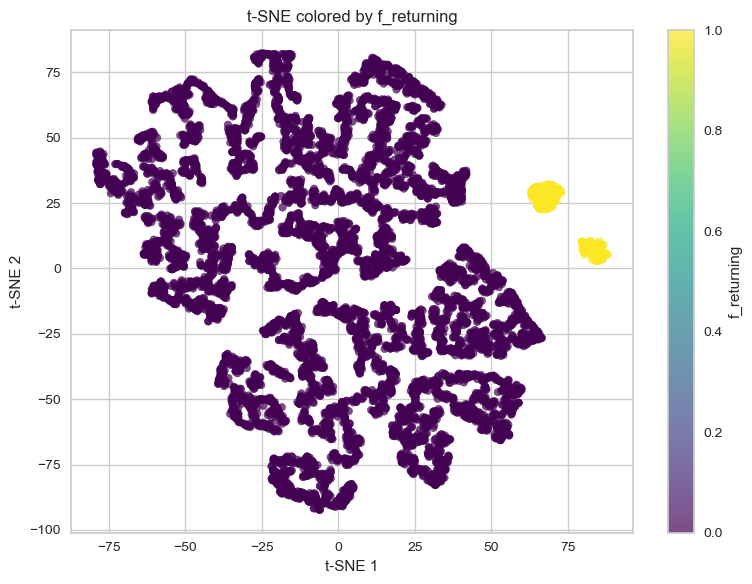

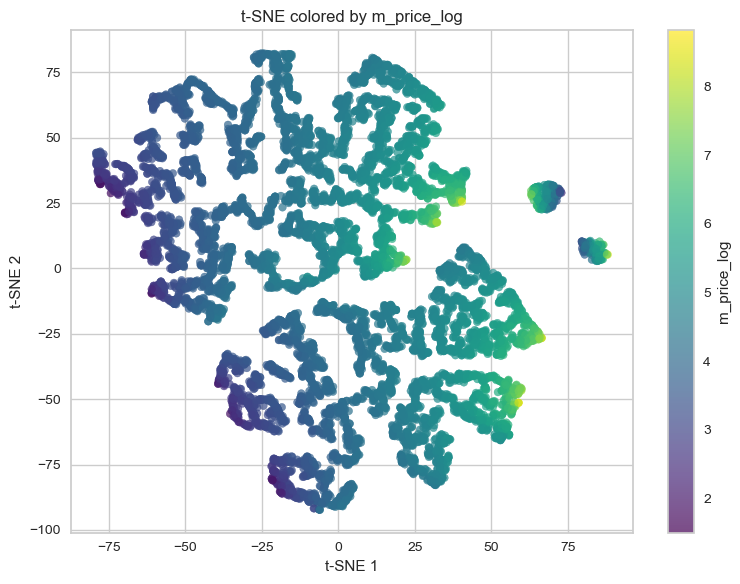

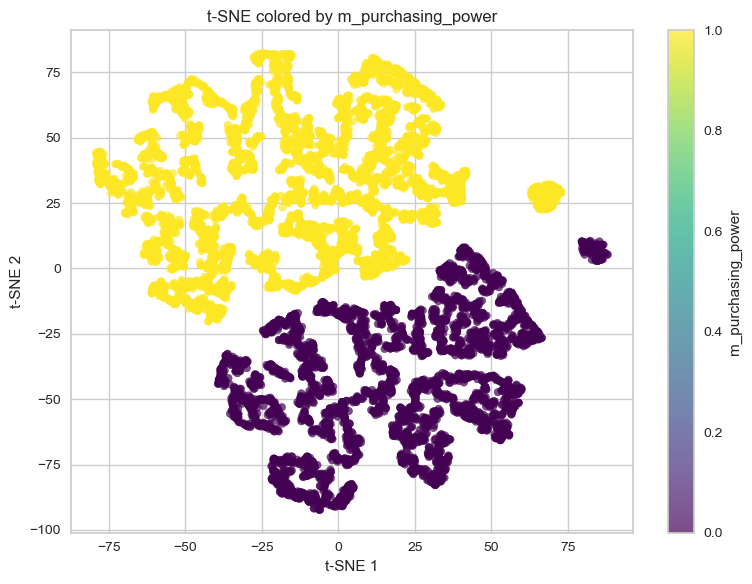

In [317]:
# 3) t-SNE visualization
df_sub = visualise_clusters(
    df,
    features=['recency','f_returning','m_price_log', 'm_purchasing_power'],
    scaler=scaler,
    km=km_model,
    subsample_size=10000,
    tsne_perplexity=40,
    save_fig=True,
    fig_dir="./plots/tests/rfm_purchasing"
)

### Model 4: RFM + installments

Clustering metrics:
    silhouette  calinski_harabasz  davies_bouldin
k                                               
2        0.66           32022.24            0.51
3        0.37           43164.87            1.00
4        0.32           50373.34            0.97
5        0.31           52701.97            0.93
6        0.29           49309.23            1.01
7        0.28           47143.19            1.07
8        0.29           45115.81            1.04


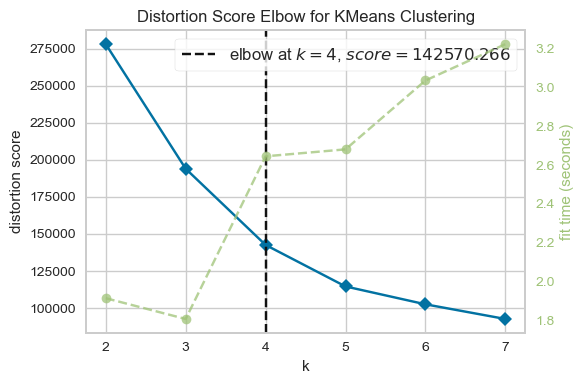

In [321]:
# 1) Evaluate cluster matrics
scaler, metrics, best_k = evaluate_k_metrics(
    df,
    features=['recency','f_returning','m_price_log', 'm_total_installments'],
    k_min=2, k_max=8,
    save_fig=True,
    fig_path="./plots/tests/rfm_installments/elbow_silhouette_rfm_inst.png"
)

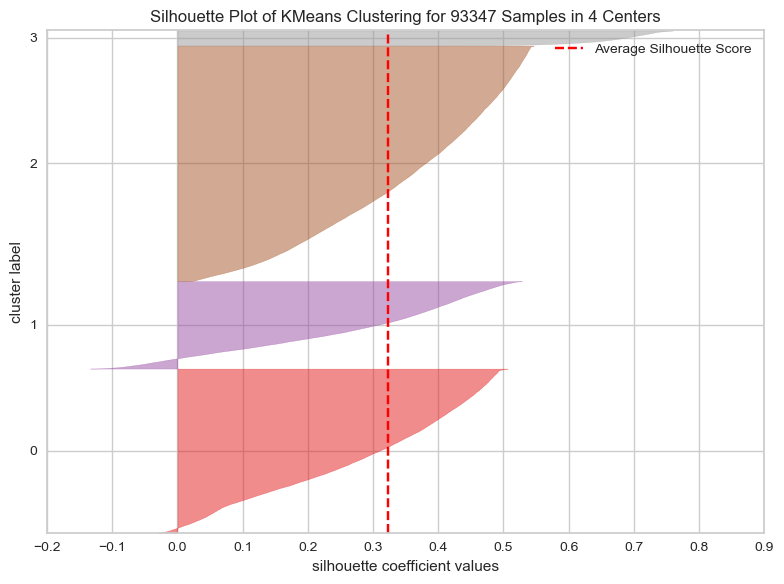

Cluster counts:
          count
cluster       
0        30504
1        16253
2        43789
3         2801
Cluster profiles:



recency  f_returning  m_price  m_total_installments
cluster                                                     
0         392.59         0.00    96.58                  2.03
1         240.53         0.00   323.11                  7.71
2         128.31         0.00    98.06                  1.83
3         219.29         1.00   260.05                  3.37

In [322]:
# 2) Fit at chosen k, get profiles
km_model, cluster_profiles = fit_best_k(
    df,
    features=['recency','f_returning','m_price_log', 'm_total_installments'],
    scaler=scaler,
    k=best_k,
    features_interpret=['recency','f_returning','m_price', 'm_total_installments'],
    save_fig=True,
    fig_path="./plots/tests/rfm_installments/silhouette_kmeans_rfm_inst.png"
)

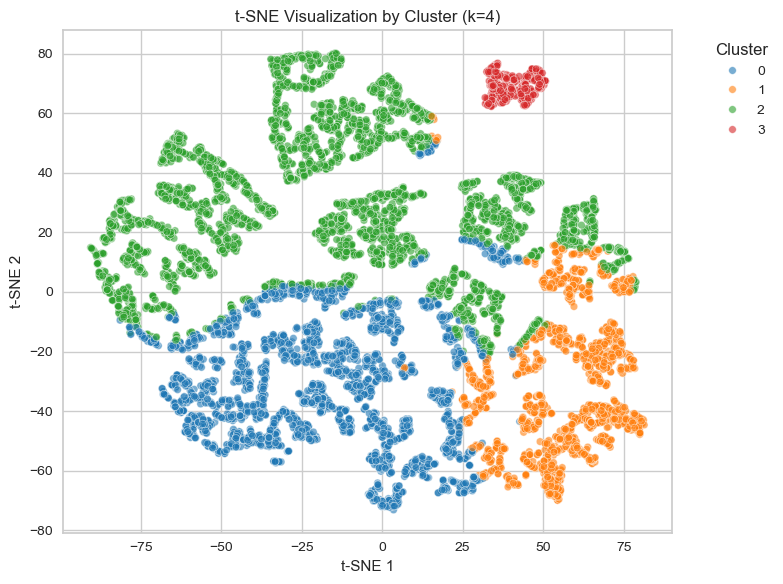

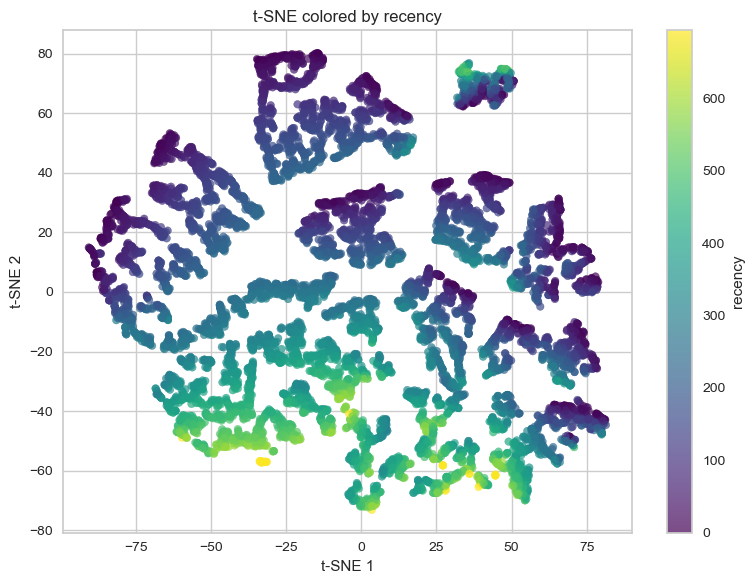

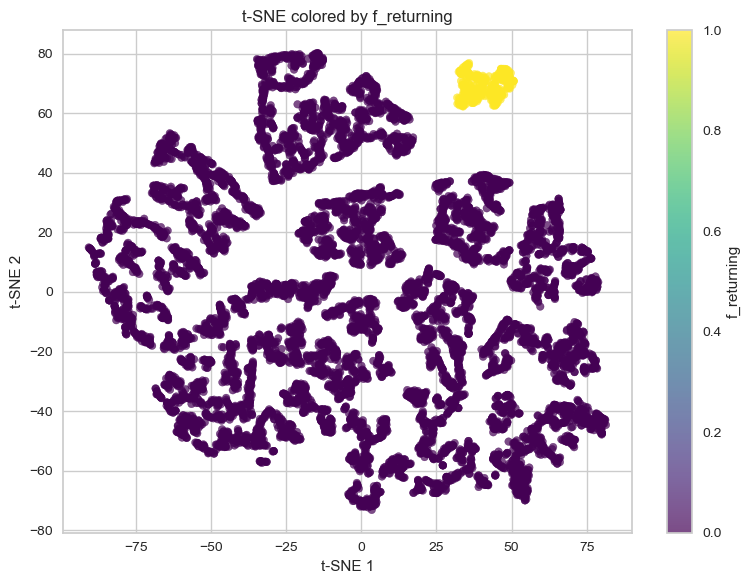

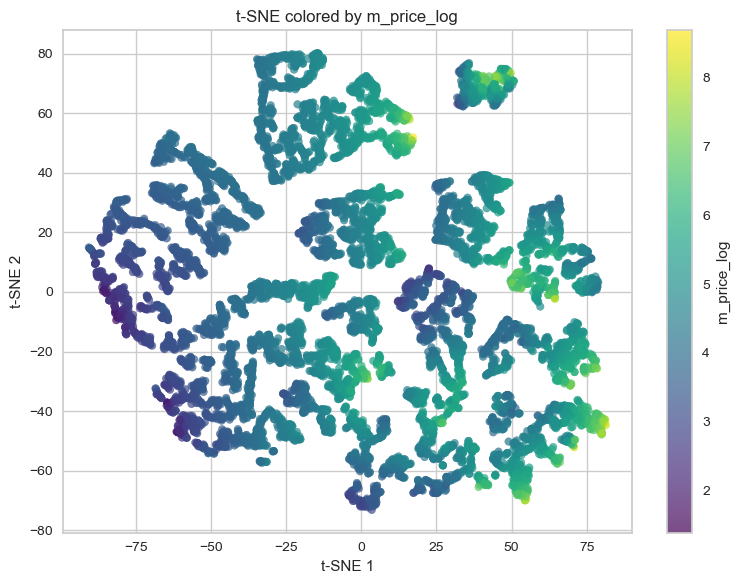

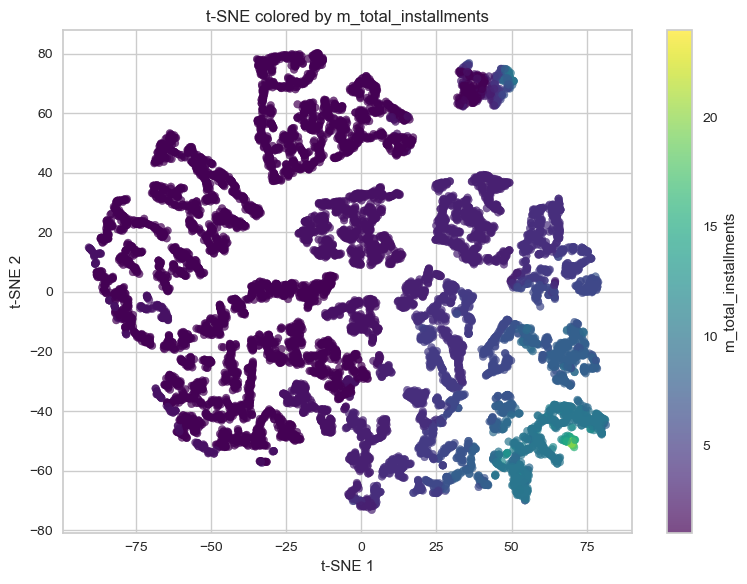

In [323]:
# 3) t-SNE visualization
df_sub = visualise_clusters(
    df,
    features=['recency','f_returning','m_price_log', 'm_total_installments'],
    scaler=scaler,
    km=km_model,
    subsample_size=10000,
    tsne_perplexity=40,
    save_fig=True,
    fig_dir="./plots/tests/rfm_installments"
)

### Model 5: RFM + Product Popularity

Clustering metrics:
    silhouette  calinski_harabasz  davies_bouldin
k                                               
2        0.65           32043.78            0.53
3        0.29           37844.09            1.18
4        0.29           40312.79            1.06
5        0.29           41770.58            0.97
6        0.30           41606.40            0.99
7        0.28           41545.50            1.00
8        0.28           40616.52            1.03


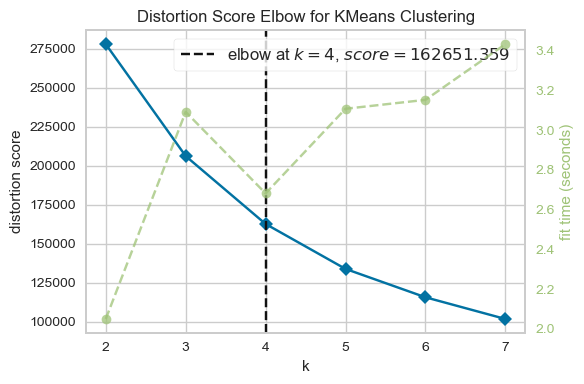

In [329]:
# 1) Evaluate cluster matrics
scaler, metrics, best_k = evaluate_k_metrics(
    df,
    features=['recency','f_returning','m_price_log', 'product_score'],
    k_min=2, k_max=8,
    save_fig=True,
    fig_path="./plots/tests/rfm_popularity/elbow_silhouette_rfm_pop.png"
)

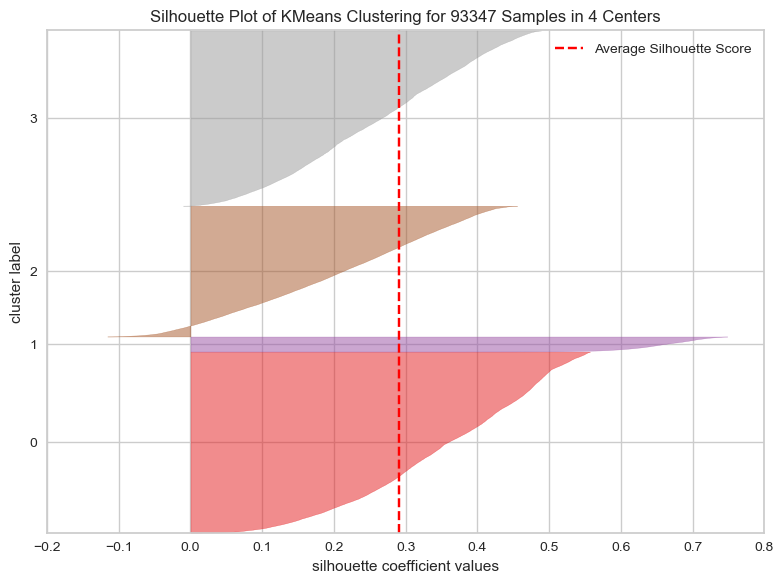

Cluster counts:
          count
cluster       
0        33662
1         2801
2        24303
3        32581
Cluster profiles:



recency  f_returning  m_price  product_score
cluster                                              
0         158.19         0.00   139.67           7.69
1         219.29         1.00   260.05           4.77
2         440.04         0.00   132.37           5.31
3         168.32         0.00   140.35           2.83

In [330]:
# 2) Fit at chosen k, get profiles
km_model, cluster_profiles = fit_best_k(
    df,
    features=['recency','f_returning','m_price_log', 'product_score'],
    scaler=scaler,
    k=best_k,
    features_interpret=['recency','f_returning','m_price', 'product_score'],
    save_fig=True,
    fig_path="./plots/tests/rfm_popularity/silhouette_kmeans_rfm_pop.png"
)

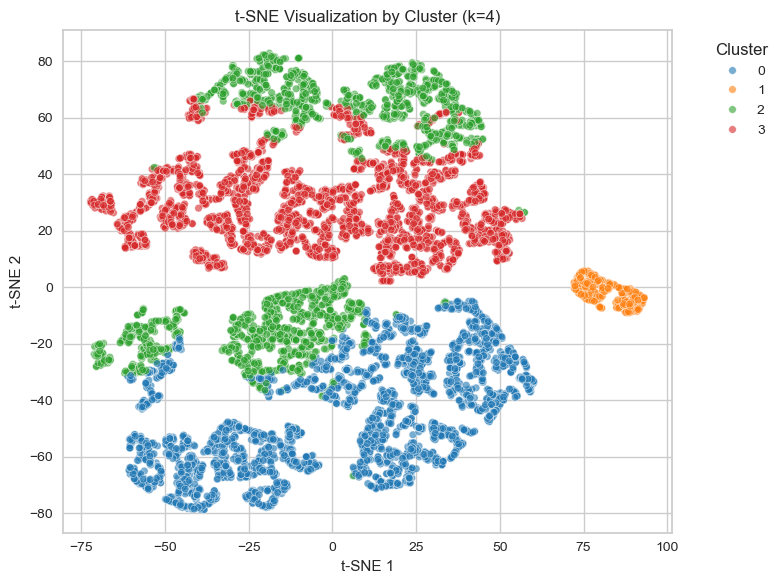

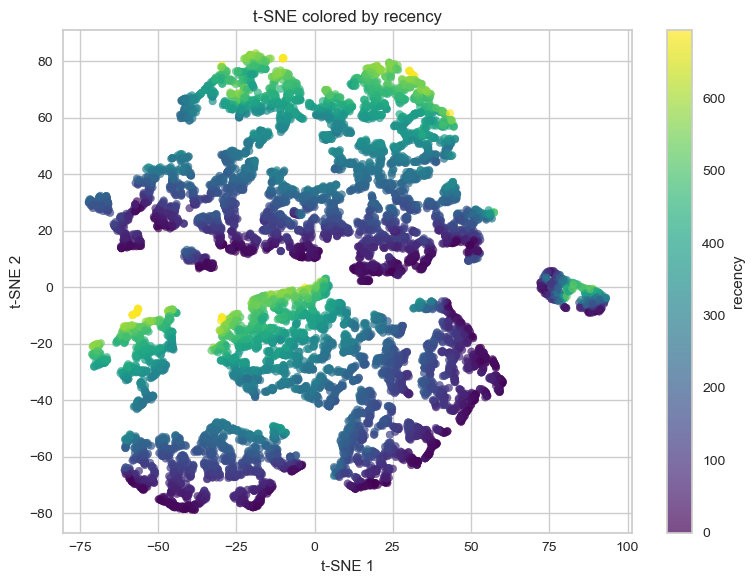

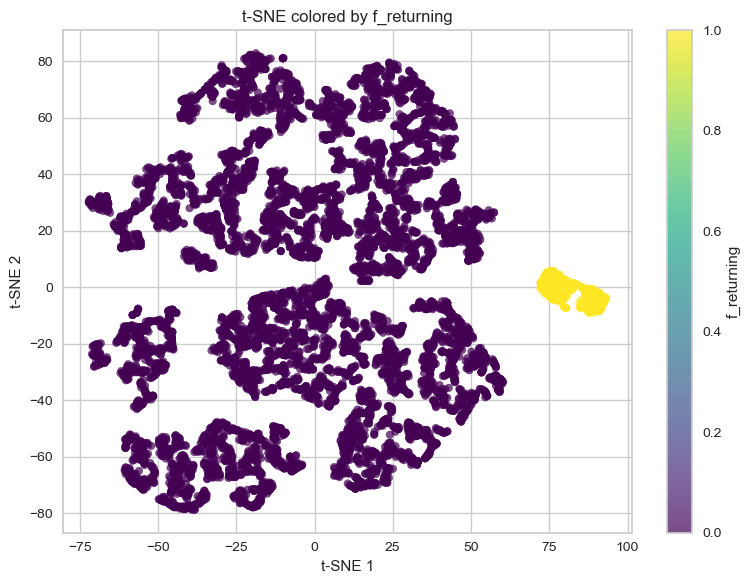

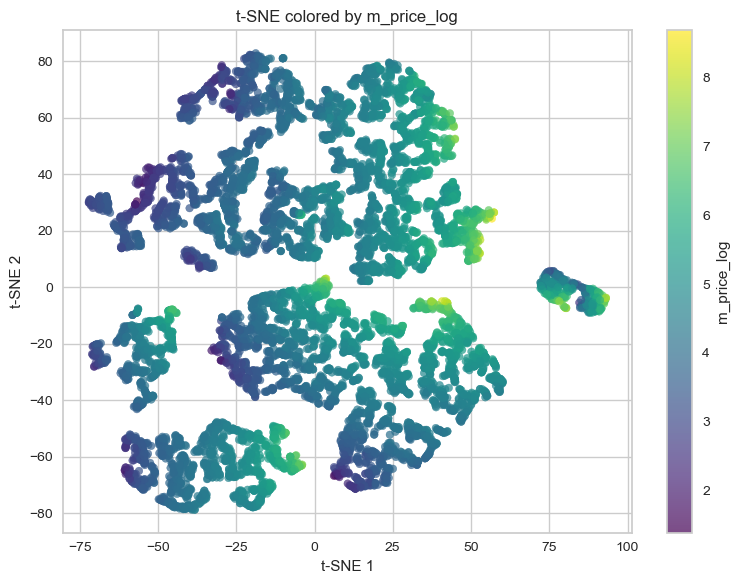

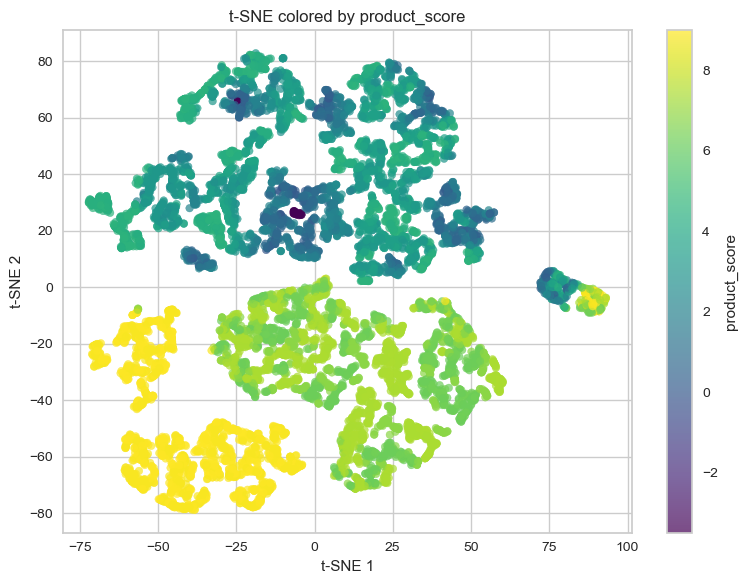

In [331]:
# 3) t-SNE visualization
df_sub = visualise_clusters(
    df,
    features=['recency','f_returning','m_price_log', 'product_score'],
    scaler=scaler,
    km=km_model,
    subsample_size=10000,
    tsne_perplexity=40,
    save_fig=True,
    fig_dir="./plots/tests/rfm_popularity"
)

## Other Clustering Approaches

### DBSCAN

In [21]:
features = ['recency', 'f_returning', 'm_price_log']

X = df[features].values
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

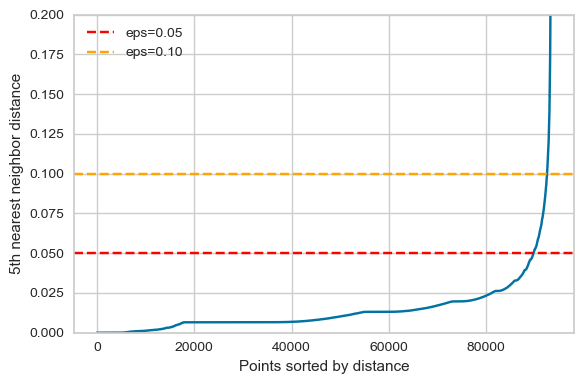

In [23]:
# 5th-NN distance plot for eps guidance
nbrs = NearestNeighbors(n_neighbors=5).fit(X_scaled)
dists, _ = nbrs.kneighbors(X_scaled)
dists = np.sort(dists[:, 4])
plt.figure(figsize=(6,4))
plt.plot(dists)
plt.ylabel("5th nearest neighbor distance")
plt.xlabel("Points sorted by distance")
plt.ylim(0, 0.2)
plt.axhline(0.05, linestyle='--', color='red', label='eps=0.05')
plt.axhline(0.10, linestyle='--', color='orange', label='eps=0.10')
plt.legend()
plt.tight_layout()
plt.savefig(f"./plots/tests/rfm/5th_nearest_neighbor_distance.png")
plt.show()

In [340]:
# DBSCAN clustering
eps_values        = [0.05, 0.1]
min_samples_vals  = [10, 100]

results = []
for eps in eps_values:
    for ms in min_samples_vals:
        db = DBSCAN(eps=eps, min_samples=ms).fit(X_scaled)
        labels = db.labels_
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise    = (labels == -1).sum()
        sil = silhouette_score(X_scaled[labels != -1], labels[labels != -1])

        results.append({
            'eps':            eps,
            'min_samples':    ms,
            'n_clusters':     n_clusters,
            'n_noise':        n_noise,
            'silhouette':     sil
        })

df_results = pd.DataFrame(results)
df_results.sort_values(['silhouette','n_clusters'], ascending=[False,True])

eps  min_samples  n_clusters  n_noise  silhouette
2 0.10           10          18     1440        0.20
3 0.10          100           8    11792       -0.04
1 0.05          100          40    51751       -0.12
0 0.05           10          77     5369       -0.17

In [29]:
# DBSCAN clustering
db = DBSCAN(eps=0.1, min_samples=100).fit(X_scaled)
labels_db = db.labels_
df['cluster_db'] = labels_db

# Observations per cluster
unique, counts = np.unique(labels_db, return_counts=True)
print(dict(zip(unique, counts)))

{-1: 11792, 0: 80119, 1: 581, 2: 194, 3: 188, 4: 102, 5: 171, 6: 100, 7: 100}


In [33]:
idx = np.random.RandomState(42).choice(len(df), size=min(10000, len(df)), replace=False)
df_sub = df.iloc[idx].copy()
    
# t-SNE embedding
X_sub = scaler.transform(df_sub[features].values)
tsne = TSNE(n_components=2, perplexity=40, init='pca', random_state=42)
Y = tsne.fit_transform(X_sub)
df_sub['tsne1'], df_sub['tsne2'] = Y[:,0], Y[:,1]

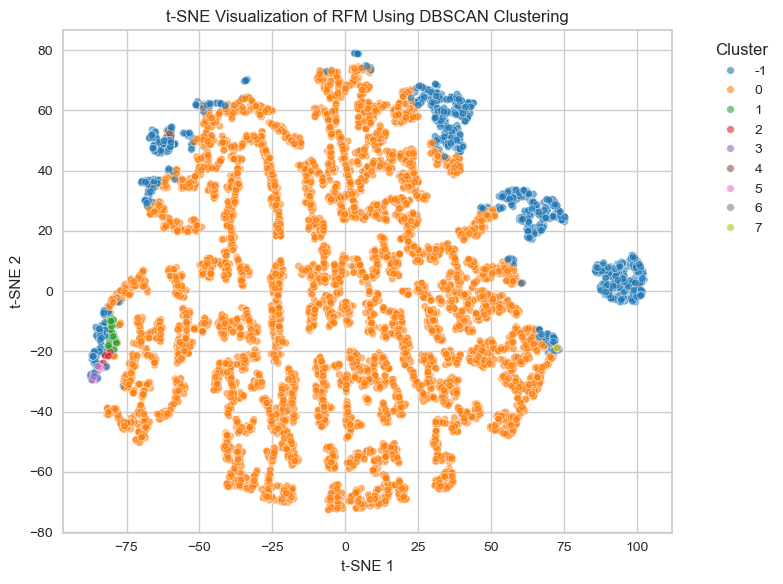

In [39]:
# Plot clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_sub, x='tsne1', y='tsne2',
                hue='cluster_db', palette='tab10',
                s=30, alpha=0.6)
plt.title(f"t-SNE Visualization of RFM Using DBSCAN Clustering")
plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(f"./plots/tests/rfm/tsne_clusters_dbscan_rmf.png")
plt.show()

DBSCAN only grabs two tiny pockets of high density and throws essentially everything else into “noise.” This behavior makes it unsuitable for a full‐spectrum marketing segmentation.

### Agglomerative clustering

Marketing specialists can use hierarchical clustering to draw a hierarchy between different types of customers based on their purchasing habits for better marketing strategies and product recommendations.

Compare dendrograms linkages to pick a sensible k for Agglomerative clustering:

In [42]:
features = ['recency', 'f_returning', 'm_price_log']

X = df[features].values
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

In [44]:
# Silhouette score for different k
idx = np.random.choice(len(X_scaled), size=20000, replace=False)
X_sub = X_scaled[idx]
for k in (3, 4, 5):
    agg = AgglomerativeClustering(n_clusters=k).fit(X_sub)
    sil = silhouette_score(X_sub, agg.labels_)
    print(f"Agglomerative (k={k}) → silhouette = {sil:.3f}")

Agglomerative (k=3) → silhouette = 0.348
Agglomerative (k=4) → silhouette = 0.340
Agglomerative (k=5) → silhouette = 0.310


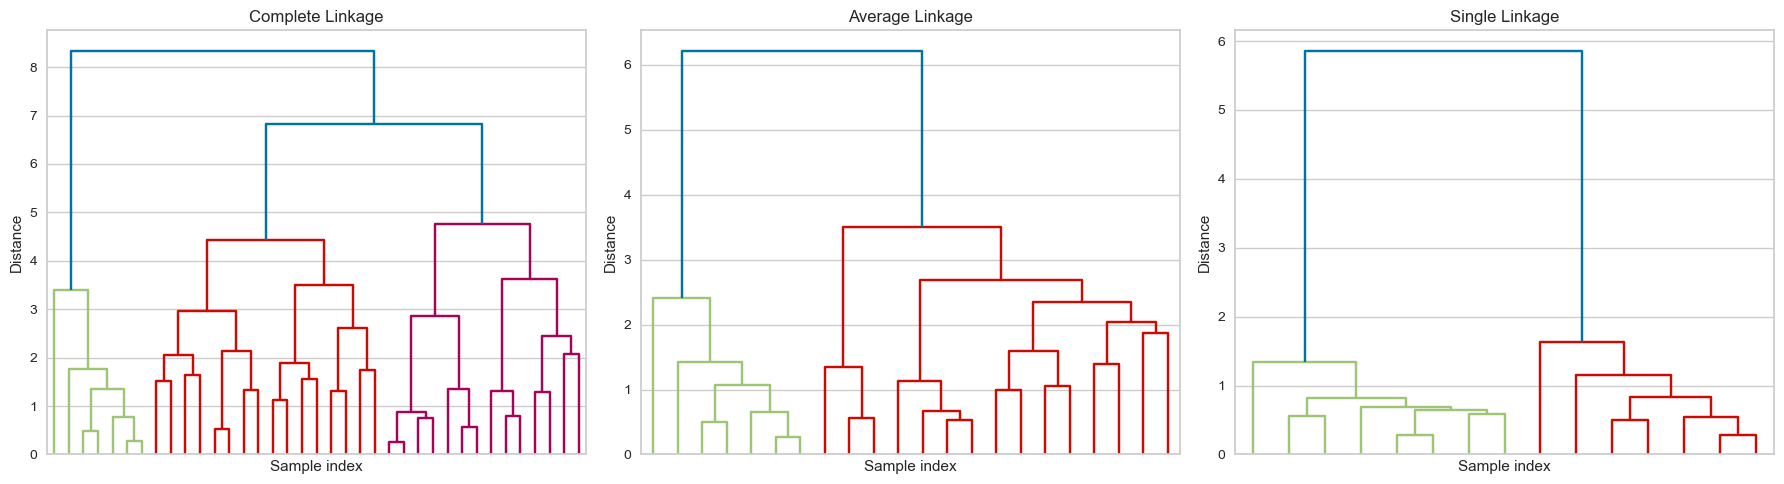

In [407]:
# Subsample for dendrogram
n_plot = 300
idx_plot = np.random.choice(len(X_sub), size=n_plot, replace=False)
X_small = X_sub[idx_plot]

# Compare linkage methods
link_complete = linkage(X_small, method="complete", metric="euclidean")
link_average  = linkage(X_small, method="average",  metric="euclidean")
link_single   = linkage(X_small, method="single",   metric="euclidean")

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for Z, name, ax in zip(
    [link_complete, link_average, link_single],
    ["complete", "average", "single"],
    axes
):
    dendrogram(
        Z,
        truncate_mode="level",
        p=5,
        no_labels=True,
        ax=ax
    )
    ax.set_title(f"{name.capitalize()} Linkage")
    ax.set_xlabel("Sample index")
    ax.set_ylabel("Distance")

plt.tight_layout()
plt.savefig(f"./plots/tests/rfm/agglomerative_linkages_rfm.png")
plt.show()

In [46]:
# Cluster the subsample
df_sub = df.iloc[idx].copy()
agg_final = AgglomerativeClustering(n_clusters=3, linkage='average').fit(X_sub)
df_sub['cluster_agg'] = agg_final.labels_

In [48]:
# t-SNE embedding
X_sub = scaler.transform(df_sub[features].values)
tsne = TSNE(n_components=2, perplexity=40, init='pca', random_state=42)
Y = tsne.fit_transform(X_sub)
df_sub['tsne1'], df_sub['tsne2'] = Y[:,0], Y[:,1]

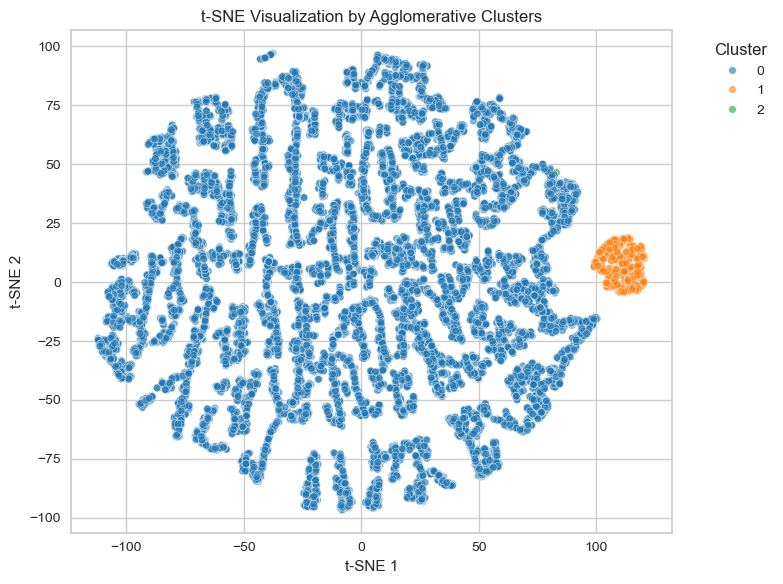

In [50]:
# Plot clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_sub, x='tsne1', y='tsne2',
                hue='cluster_agg', palette='tab10',
                s=30, alpha=0.6)
plt.title(f"t-SNE Visualization by Agglomerative Clusters")
plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(f"./plots/tests/rfm/tsne_clusters_agg_rfm.png")
plt.show()

In [58]:
features_interpret=['recency','f_returning','m_price']
profiles = df_sub.groupby('cluster_agg')[features_interpret].mean().round(2)
profiles

recency  f_returning  m_price
cluster_agg                               
0             238.97         0.00   139.28
1             222.14         1.00   253.44
2             333.00         0.00 13440.00

In [62]:
df_sub['cluster_agg'].value_counts(normalize=True)

cluster_agg
0   0.97
1   0.03
2   0.00
Name: proportion, dtype: float64

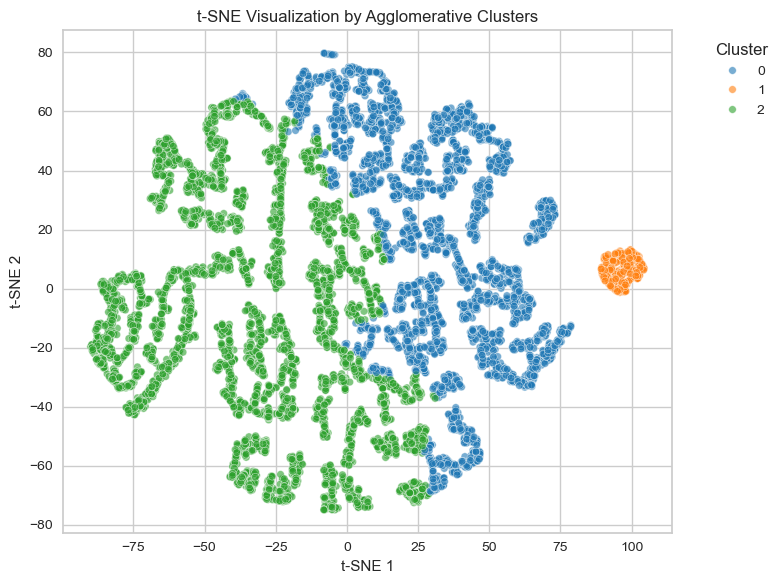

In [419]:
# Plot clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_sub, x='tsne1', y='tsne2',
                hue='cluster_agg', palette='tab10',
                s=30, alpha=0.6)
plt.title(f"t-SNE Visualization by Agglomerative Clusters")
plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2")
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(f"./plots/tests/rfm/tsne_clusters_agg_rfm.png")
plt.show()

One of the weaknesses of hierarchical clustering is that it is sensitive to outliers.